In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt
import emcee
import corner
from PIL import Image
from scipy import stats

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sin = lambda x: np.sin(np.deg2rad(x))
cos = lambda x: np.cos(np.deg2rad(x))
tan = lambda x: np.tan(np.deg2rad(x))

In [3]:
df = pd.read_csv('cepheid.csv')

In [4]:
d = 1 / df['parallax']
l = df['l']
b = df['b']
x0 = 8.34
z0 = 0.027

x = x0 - d * cos(l) * cos(b)
y = d * sin(l) * cos(b)
z = d * sin(b) + z0
r = np.sqrt(x**2 + y**2)
fi = np.where(x < 0, np.arctan(y/x) * 180 / np.pi + 180, np.arctan(y/x) * 180 / np.pi)
fi = np.where(fi < 0, fi + 360, fi*1)

batas = 40

df['x'], df['y'], df['z'], df['r'], df['fi'] = x, y, z, r, fi
df = df[(df['x'] < batas) & (df['x'] > -batas) & (df['y'] < batas) & (df['y'] > -batas) & (df['z'] < batas) & (df['z'] > -batas)]

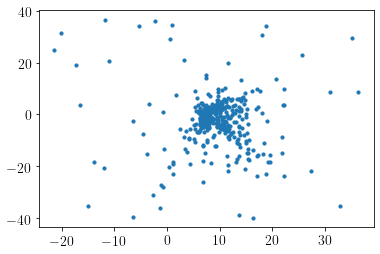

In [6]:
plt.scatter(df['x'], df['y'], s = 10)

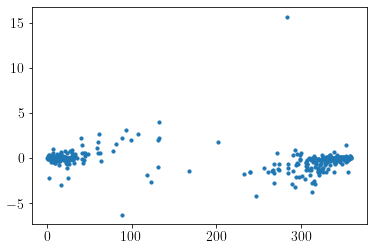

In [7]:
plt.scatter(df['fi'], df['z'], s = 10)

[ 6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5
 13.  13.5 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5
 20.  20.5 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25. ] [  0  30  60  90 120 150 180 210 240 270 300 330 360]


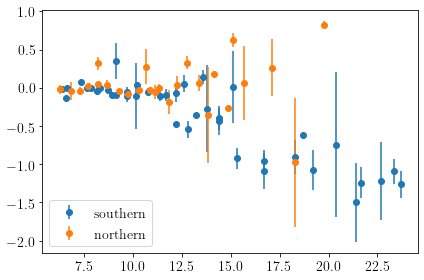

In [14]:
er = df['r'].to_numpy()
ef = df['fi'].to_numpy()
ez = df['z'].to_numpy()

gabung = er, ef, ez

r_delta = .5
r_bawah = 6.
r_atas = 25.
r_atas = r_delta + r_atas

eff = 0
f_delta = 30
f_bawah = 0
f_atas = 360
f_atas = f_delta + f_atas

binr = np.arange(r_bawah, r_atas, r_delta)
binf = np.arange(f_bawah, f_atas, f_delta)

print (binr, binf)

median = stats.binned_statistic_2d(er, ef, values=gabung, statistic='median', bins=(binr, binf))
mean = stats.binned_statistic_2d(er, ef, values=gabung, statistic='mean', bins=(binr, binf))
count = stats.binned_statistic_2d(er, ef, values=gabung, statistic='count', bins=(binr, binf))
std = stats.binned_statistic_2d(er, ef, values=gabung, statistic='std', bins=(binr, binf))

jumlah = np.ravel(count.statistic[0])
std_z = np.ravel(std.statistic[2])

min_r = np.ravel(mean.statistic[0])
min_f = np.ravel(mean.statistic[1])
min_z = np.ravel(mean.statistic[2])

med_r = np.ravel(median.statistic[0])
med_f = np.ravel(median.statistic[1])
med_z = np.ravel(median.statistic[2])

minimal = 1

jumlah_s = jumlah[jumlah > minimal]
std_z = std_z[jumlah > minimal]
std_z_ed = std_z / np.sqrt(jumlah_s)

min_r = min_r[jumlah > minimal]
min_f = min_f[jumlah > minimal]
min_z = min_z[jumlah > minimal]

med_r = med_r[jumlah > minimal]
med_f = med_f[jumlah > minimal]
med_z = med_z[jumlah > minimal]

df1 = pd.DataFrame([med_r, med_f, med_z, std_z, std_z_ed])
df1 = df1.T
df1.columns = ['r', 'fi', 'z', 'std_z', 'std_z_ed', ]

df2 = df1[df1['fi'] > 180]
df3 = df1[df1['fi'] < 180]

plt.errorbar(df2['r'], df2['z'], yerr=df2['std_z_ed'], fmt = 'o', label = 'southern')
plt.errorbar(df3['r'], df3['z'], yerr=df3['std_z_ed'], fmt = 'o', label = 'northern')

plt.legend()
plt.tight_layout()

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 30:  14%|█▍        | 28999/200000 [00:19<01:55, 1474.99it/s]    
Convergence achieved at 29000
Interrupted at 28,999 [14%]: Average Loss = 652.05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [R1, sd1, sd0, fi1, fi0, amp1, amp0]
Sampling 2 chains, 0 divergences: 100%|██████████| 40000/40000 [03:23<00:00, 196.57draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 36.079:   7%|▋         | 14899/200000 [00:07<01:38, 1881.85it/s]
Convergence achieved at 14900
Interrupted at 14,899 [7%]: Average Loss = 453.99
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, fi0, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 40000/40000 [00:34<00:00, 1173.94draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72c04ff4c0>,
      dtype=object)

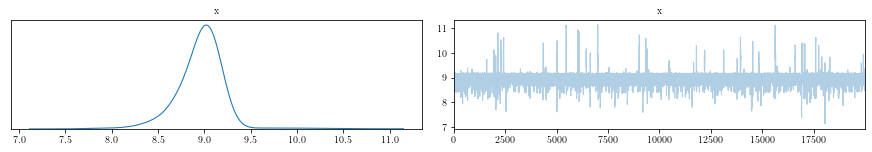

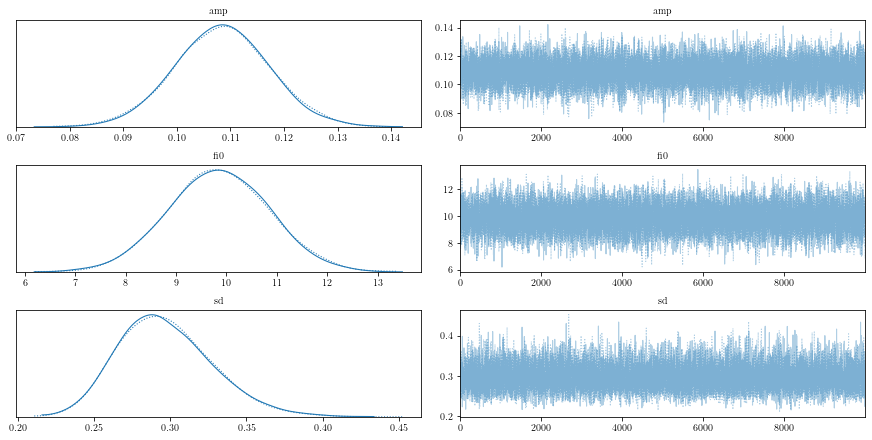

In [18]:
N = df1['r'].count()
rmaks = df1['r'].max()
rmin = df1['r'].min()

r = df1['r'].to_numpy()
fi = df1['fi'].to_numpy()
z = df1['z'].to_numpy()

def logistic(L, x0, k=N, t=np.linspace(rmin, rmaks, N)):
    return L / (1 + tt.exp(-k * (t - x0)))

draw = 10_000
rantai = 2
seed = 6

with pm.Model() as m0:
    betas1 = pm.Normal('amp0', 0., 1.)
    betas2 = pm.Normal('amp1', 0., 1.)
    
    gammas1 = pm.Normal('fi0', 15., 5.)
    gammas2 = pm.Normal('fi1', 15., 5.)
    
    sd1 = pm.HalfNormal('sd0', .5)
    sd2 = pm.HalfNormal('sd1', .5)
    
    switchpoints = pm.Normal('R1', 8.5, .5)
    
    amp = betas1 + logistic(betas2, switchpoints)
    fi0 = gammas1 + logistic(gammas2, switchpoints)
    dev = sd1 + logistic(sd2, switchpoints)
    
    er_r1 = np.linspace(rmin, rmaks, N)
    warp = amp * er_r1 * np.sin(np.deg2rad(fi -fi0))

    observed = pm.Normal('Z model', mu=warp, sd=dev, observed=z)
    trace0 = pm.sample(draw, tune=draw, chains=rantai, random_seed=seed, init='advi+adapt_diag', nuts_kwargs={'target_accept':0.95})
    
    
r1 = np.median(trace0['R1'])
fi00 = np.median(trace0['fi1'])

df2 = df1[df1['r'] > r1]

rr = df2['r'].to_numpy()
zz = df2['z'].to_numpy()
ff = df2['fi'].to_numpy()

with pm.Model() as m:
    amp = pm.Normal('amp', .1, 1.)
    fi0 = pm.Normal('fi0', fi00, 1.)
    dev = pm.HalfNormal('sd', .5)
    
    er_r1 = rr - r1
    warp = amp * er_r1 * np.sin(np.deg2rad(ff -fi0))

    observed = pm.Normal('Z model', mu=warp, sd=dev, observed=zz)
    trace = pm.sample(draw, tune=draw, chains=rantai, init='advi+adapt_diag', random_seed=seed, nuts_kwargs={'target_accept':0.95})

pm.traceplot(trace0['R1'])
pm.traceplot(trace)


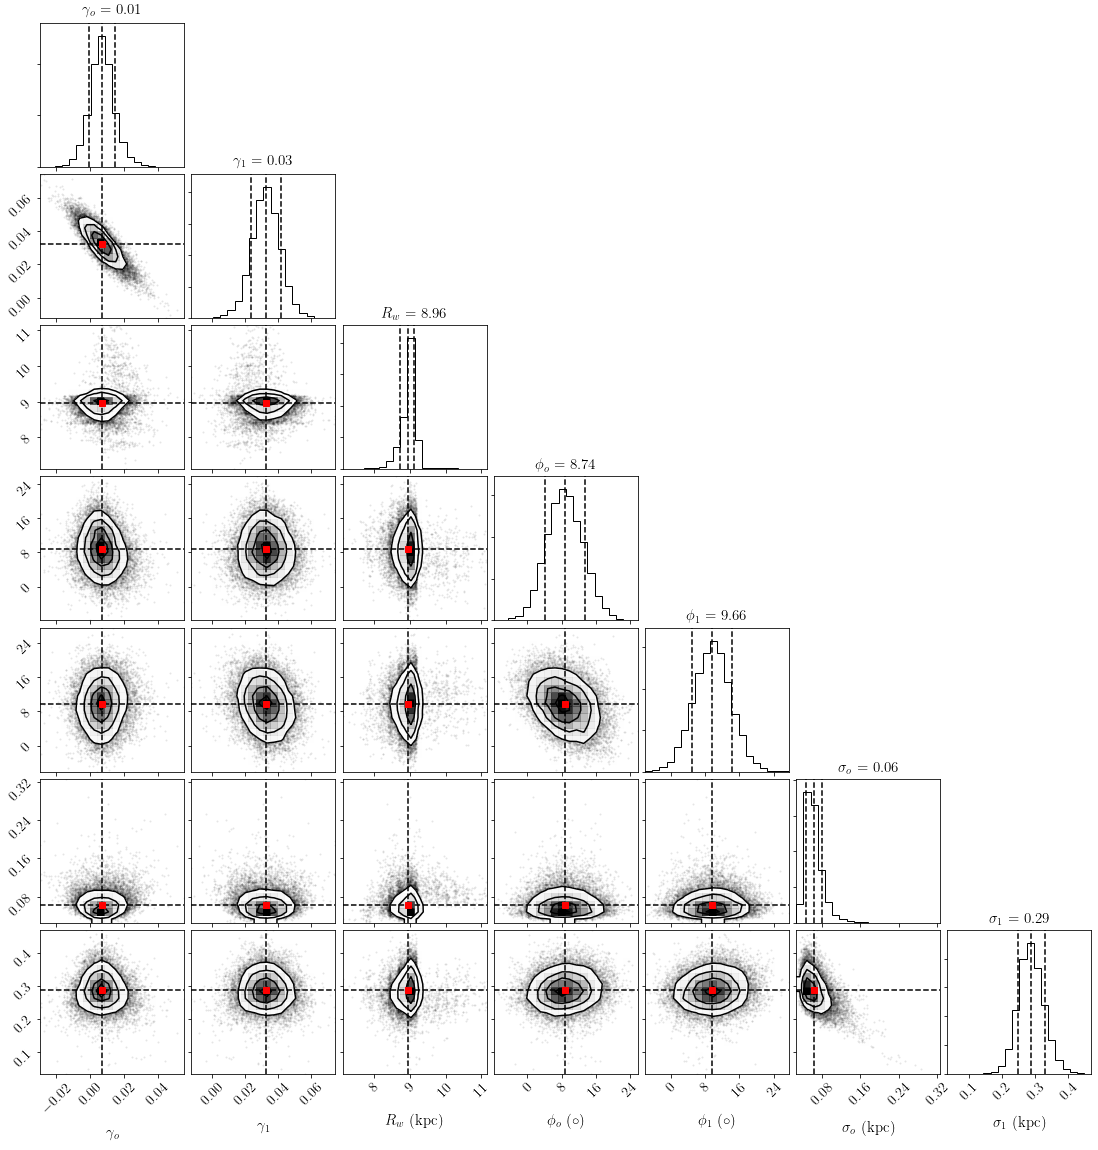

In [43]:
amp0 = trace0['amp0']
amp1 = trace0['amp1']

fi0 = trace0['fi0']
fi1 = trace0['fi1']

er1 = trace0['R1']

sd0 = trace0['sd0']
sd1 = trace0['sd1']

postsamples = np.vstack((amp0, amp1, er1, fi0, fi1, sd0, sd1)).T

fig = corner.corner(postsamples)

ndim = postsamples.shape[1]
axes = np.array(fig.axes).reshape((ndim, ndim))

names = ['$\gamma_o$', '$\gamma_1$', '$R_w$', '$\phi_o$', '$\phi_1$', '$\sigma_o$', '$\sigma_1$']
xlabel = ['$\gamma_o$', '$\gamma_1$', '$R_w$ (kpc)', '$\phi_o$ ($\circ$)', 
          '$\phi_1$ ($\circ$)', '$\sigma_o$ (kpc)', '$\sigma_1$ (kpc)']
q1 = np.quantile(postsamples, .14, axis = 0)
q2 = np.quantile(postsamples, .86, axis = 0)
value2 = np.mean(postsamples, axis=0)


for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value2[i], color="black", linestyle = 'dashed')
    ax.axvline(q1[i], color="black", linestyle = 'dashed')
    ax.axvline(q2[i], color="black", linestyle = 'dashed')
    strq1 = str(q1[i])
    judul = names[i] + ' $ = $ ' + str(np.round(value2[i], 2))
    ax.set_title(judul, fontsize= 15)
    
for yi in range(ndim):
    
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value2[xi], color="black", linestyle = 'dashed')
        ax.axhline(value2[yi], color="black", linestyle = 'dashed')
        ax.plot(value2[xi], value2[yi], "sr")
        ax.set_xlabel(xlabel[xi], labelpad = 15, fontsize = 15)
        
plt.xlabel(xlabel[-1], labelpad = 15, fontsize = 15);

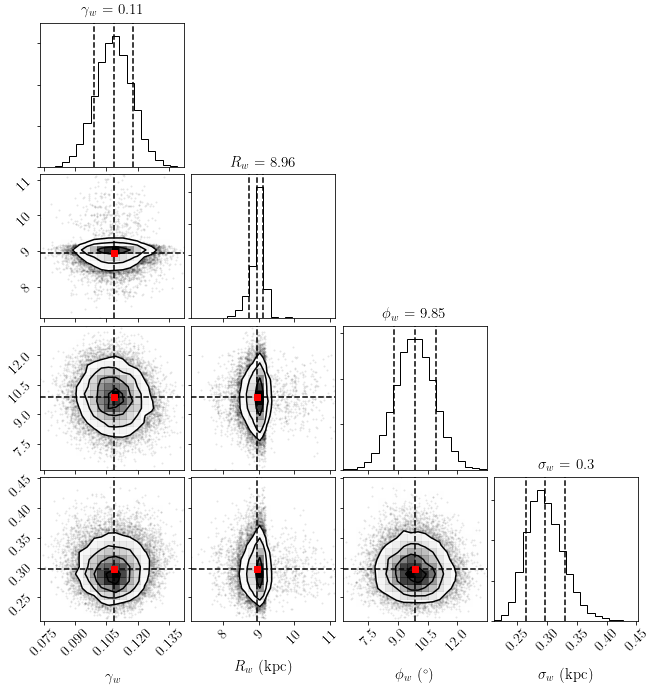

In [73]:
amp1 = trace['amp']
fi1 = trace['fi0']
er1 = trace0['R1']
sd1 = trace['sd']

postsamples = np.vstack((amp1, er1, fi1, sd1)).T

fig = corner.corner(postsamples)

ndim = postsamples.shape[1]
axes = np.array(fig.axes).reshape((ndim, ndim))

names = ['$\gamma_w$', '$R_w$', '$\phi_w$', '$\sigma_w$']
xlabel = ['$\gamma_w$', '$R_w$ (kpc)', '$\phi_w$ $(^\circ)$', '$\sigma_w$ (kpc)']
q1 = np.quantile(postsamples, .14, axis = 0)
q2 = np.quantile(postsamples, .86, axis = 0)
value2 = np.mean(postsamples, axis=0)


for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value2[i], color="black", linestyle = 'dashed')
    ax.axvline(q1[i], color="black", linestyle = 'dashed')
    ax.axvline(q2[i], color="black", linestyle = 'dashed')
    strq1 = str(q1[i])
    judul = names[i] + ' $ = $ ' + str(np.round(value2[i], 2))
    ax.set_title(judul, fontsize= 15)
    
for yi in range(ndim):
    
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value2[xi], color="black", linestyle = 'dashed')
        ax.axhline(value2[yi], color="black", linestyle = 'dashed')
        ax.plot(value2[xi], value2[yi], "sr")
        ax.set_xlabel(xlabel[xi], labelpad = 15, fontsize = 15)
        
plt.xlabel(xlabel[-1], labelpad = 15, fontsize = 15);

In [74]:
az.ess(trace0), az.ess(trace), az.mcse(trace0), az.mcse(trace)

(<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     amp0     float64 5.848e+03
     amp1     float64 6.221e+03
     fi0      float64 1.225e+04
     fi1      float64 1.311e+04
     R1       float64 3.455e+03
     sd0      float64 6.542e+03
     sd1      float64 9.924e+03,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     amp      float64 1.435e+04
     fi0      float64 1.709e+04
     sd       float64 1.818e+04,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     amp0     float64 0.0001006
     amp1     float64 0.0001113
     fi0      float64 0.03865
     fi1      float64 0.03766
     R1       float64 0.005705
     sd0      float64 0.0002864
     sd1      float64 0.0004097,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     amp      float64 7.348e-05
     fi0      float64 0.00755
     sd       float64 0.0002328)

In [75]:
kat_r1 = az.hpd(er1, credible_interval=.95)
kat_amp = az.hpd(amp1, credible_interval=.95)
kat_fi0 = az.hpd(fi1, credible_interval=.95)

CI_r1 = (er1 > kat_r1[0]) & (er1 < kat_r1[1])
CI_amp = (amp1 > kat_amp[0]) & (amp1 < kat_amp[1])
CI_fi0 = (fi1 > kat_fi0[0]) & (fi1 < kat_fi0[1])

awi = amp1[CI_amp]
fwi = fi1[CI_fi0]
rwi = er1[CI_r1]

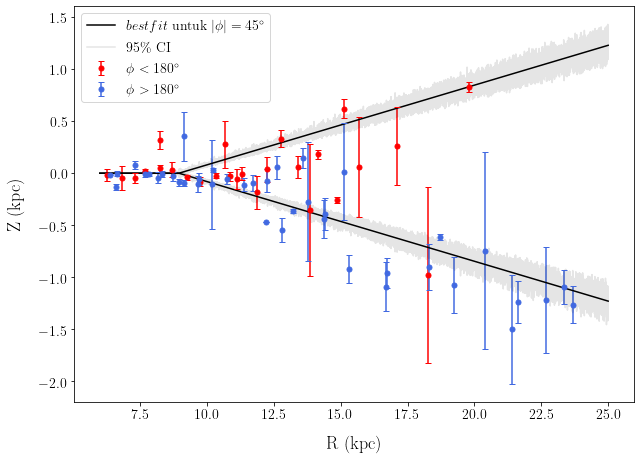

In [77]:
warna = 'k'

dfii = df1[(df1['fi'] < 180) ]
dfiim = df1[(df1['fi'] > 180)]

minminf1 = np.mean(dfii['fi'])
minminf2 = np.mean(dfiim['fi'])

aw_best = np.mean(amp1)
fw_best = np.mean(fi1)
rw_best = np.mean(er1)

ermax = dfiim['r'].max()
xx = np.linspace(6., 25., rwi.shape[0])

eff1 = 45 + fw_best
eff2 = -45 + fw_best

warp_simple1 = np.where(xx < rw_best, 0, aw_best * (xx - rw_best) * np.sin(np.deg2rad(eff1 - fw_best)))
warp_simple2 = np.where(xx < rw_best, 0, aw_best * (xx - rw_best) * np.sin(np.deg2rad(eff2 - fw_best)))

warpi1 = np.where(xx < rwi, 0, awi * (xx - rwi) * np.sin(np.deg2rad(eff1 - fwi)))
warpi2 = np.where(xx < rwi, 0, awi * (xx - rwi) * np.sin(np.deg2rad(eff2 - fwi)))

plt.figure(figsize=(9, 6.5))

plt.plot(xx, warp_simple1, c = warna, label = '$best fit$ untuk $|\phi| = 45^\circ$')
plt.plot(xx, warp_simple2, c = warna, )

plt.plot(xx, warpi1, c = warna, alpha = .1, label = '$95\%$ CI')
plt.plot(xx, warpi2, c = warna , alpha = .1)

plt.errorbar(dfii['r'], dfii['z'], dfii['std_z_ed'], fmt = 'o', ms = 5, c= 'red', ecolor='red', 
             capsize=3, label = '$\phi$ $< 180^\circ$')
plt.errorbar(dfiim['r'], dfiim['z'], dfiim['std_z_ed'], fmt = 'o', ms = 5, c= 'royalblue', ecolor='royalblue', 
             capsize=3, label = '$\phi$ $> 180^\circ$')

warna = 'k'

plt.xlabel('R (kpc)', fontsize = 18, labelpad = 14)
plt.ylabel('Z (kpc)', fontsize = 18, labelpad = 14)
plt.legend(loc = 'best')
plt.tight_layout()